In [1]:
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed.")

TensorFlow version: 2.16.1


In [2]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test) = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 1597s 9us/step


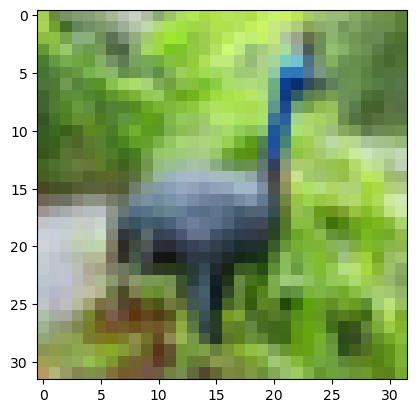

In [10]:
plt.imshow(x_train[6])

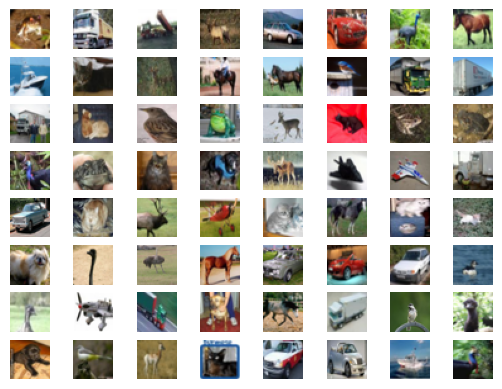

In [11]:
for i in range(64):

  plt.subplot(8,8,1+i)

  plt.axis('off')

  plt.imshow(x_train[i])

plt.show()

In [12]:
x_train.shape


(50000, 32, 32, 3)

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,LeakyReLU,Dropout
from keras.optimizers import Adam
import numpy as np
from tensorflow.keras.utils import plot_model

In [18]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), padding="same", strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), padding="same", strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), padding="same", strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model



In [19]:
model = discriminator()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def load_real_sample():

  (x_train,_),(_,_) = load_data()

  x = x_train.astype('float32')

  x = (x-127.5)/127.5

  return x

In [22]:
x = load_real_sample()
x.shape

(50000, 32, 32, 3)

In [23]:
def generate_real_sample(dataset,n_sample):

  ix = np.random.randint(0,dataset.shape[0],n_sample)

  x = dataset[ix]
  y = np.ones((n_sample,1))

  return x,y

In [24]:
def generate_fake_sample(n_sample):

  x = np.random.rand(32 * 32 * 3 * n_sample)
  x = -1 + x * 2
  x = x.reshape((n_sample,32,32,3))

  y = np.zeros((n_sample,1))

  return x,y

In [25]:
x,y = generate_fake_sample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


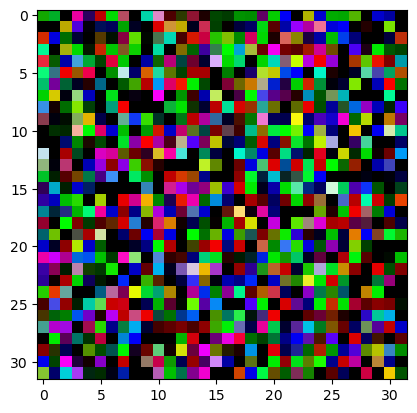

In [26]:
plt.imshow(x[0])

In [30]:
def train_descriminator(model,dataset,n_iter=40,n_batch=128):

  half_batch = n_batch//2

  for i in range(n_iter):

    x_real,y_real = generate_real_sample(dataset,half_batch)

    _,real_acc = model.train_on_batch(x_real,y_real)

    x_fake,y_fake = generate_fake_sample(half_batch)

    _,fake_acc = model.train_on_batch(x_fake,y_fake)

    print(f'{i+1} . real = {real_acc * 100}% , fake = {fake_acc * 100}% ')

In [31]:
model = discriminator()

dataset = load_real_sample()

train_descriminator(model,dataset)

1 . real = 53.125% , fake = 27.34375% 
2 . real = 50.52083134651184% , fake = 39.453125% 
3 . real = 51.249998807907104% , fake = 48.69791567325592% 
4 . real = 54.46428656578064% , fake = 54.6875% 
5 . real = 59.20138955116272% , fake = 62.968748807907104% 
6 . real = 65.34090638160706% , fake = 68.09895634651184% 
7 . real = 70.43269276618958% , fake = 72.54464030265808% 
8 . real = 73.85416626930237% , fake = 75.48828125% 
9 . real = 76.3786792755127% , fake = 77.69097089767456% 
10 . real = 78.70065569877625% , fake = 79.7656238079071% 
11 . real = 80.5059552192688% , fake = 81.39204382896423% 
12 . real = 81.92934989929199% , fake = 82.68229365348816% 
13 . real = 83.24999809265137% , fake = 83.8942289352417% 
14 . real = 84.25925970077515% , fake = 84.82142686843872% 
15 . real = 85.23706793785095% , fake = 85.72916388511658% 
16 . real = 86.13911271095276% , fake = 86.572265625% 
17 . real = 86.88446879386902% , fake = 87.27021813392639% 
18 . real = 87.63392567634583% , fake = 

In [32]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Conv2DTranspose,LeakyReLU

In [33]:
def generator(latent_dim):

  model = Sequential()

  n_nodes = 256 * 4 * 4

  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((4,4,256)))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))

  return model

In [34]:
model1 = generator(100)

model1.summary()

C:\Users\Navneet Sharma\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
def generate_latent_points(latent_dim,n_sample):

  x_input = np.random.randn(latent_dim * n_sample)
  x_input = x_input.reshape(n_sample,latent_dim)

  return x_input

In [36]:
def generate_fake_sample_by_generator(g_model,latent_dim,n_sample):

  x_input = generate_latent_points(latent_dim,n_sample)

  x = g_model.predict(x_input)

  y = np.zeros((n_sample,1))

  return x,y

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 


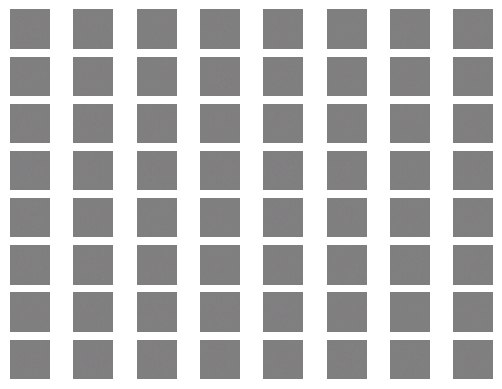

In [37]:
model = generator(100)

x,y = generate_fake_sample_by_generator(model,100,64)

x = (x+1)/2.0

for i in range(64):

  plt.subplot(8,8,1+i)

  plt.axis('off')

  plt.imshow(x[i])

plt.show()

In [42]:
def gan(g_model,d_model):

  d_model.trainable = False

  model = Sequential()

  model.add(g_model)

  model.add(d_model)

  opt = Adam(learning_rate = 0.0002,beta_1 = 0.5)

  model.compile(optimizer = opt,loss = 'binary_crossentropy')

  return model

In [43]:
d_model = discriminator()

g_model = generator(100)

model = gan(g_model,d_model)

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_19 (Sequential)      │ ?                      │     1,466,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_18 (Sequential)      │ ?                      │       522,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [44]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=20,n_batch=128):

  batch_per_epoch = dataset.shape[0]//n_batch
  half_batch = n_batch//2

  for i in range(n_epochs):
    for j in range(batch_per_epoch):

      x_real,y_real = generate_real_sample(dataset,half_batch)

      d_loss1,_ = d_model.train_on_batch(x_real,y_real)

      x_fake,y_fake = generate_fake_sample_by_generator(g_model,latent_dim,half_batch)

      d_loss2,_ = d_model.train_on_batch(x_fake,y_fake)

      x_gan = generate_latent_points(latent_dim,n_batch)

      y_gan = np.ones((n_batch,1))

      g_loss = gan_model.train_on_batch(x_gan,y_gan)

      print(f'{i+1}. {j+1}/{batch_per_epoch} : d1 = {d_loss1} , d2 = {d_loss2} , g = {g_loss}')

    if (i+1)%10 == 0:
      summerize_function(i,g_model,d_model,dataset,latent_dim)

In [45]:
def summerize_function(i,g_model,d_model,dataset,latent_dim,n_samples = 150):

  x_real,y_real = generate_real_sample(dataset,n_samples)

  _,acc_real = d_model.evaluate(x_real,y_real)

  x_fake,y_fake = generate_fake_sample_by_generator(g_model,latent_dim,n_samples)

  _,acc_fake = d_model.evaluate(x_fake,y_fake)

  print(f'Descriminator Accuracy: Real = {acc_real} , Fake = {acc_fake}')

  save_plot(x_fake,i)

  filename = 'generator_model_%03d.h5' % (i+1)
  g_model.save(filename)

In [47]:
def save_plot(example,epoch,n=7):

  example = (example + 1)/2.0

  for i in range(n * n):
    plt.subplot(n,n,i+1)

    plt.axis('off')

    plt.imshow(example[i])

  filename = 'generated_plot_e%03d.png' % (epoch+1)

  plt.savefig(filename)
  plt.close()


d_model = discriminator()

g_model = generator(100)

gan_model = gan(g_model,d_model)

In [48]:
train(g_model,d_model,gan_model,dataset,latent_dim=100,n_epochs=200,n_batch=128)


C:\Users\Navneet Sharma\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1. 1/390 : d1 = 0.6946626305580139 , d2 = 0.693881630897522 , g = [array(0.69388163, dtype=float32), array(0.69388163, dtype=float32), array(0.5078125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1. 2/390 : d1 = 0.69277024269104 , d2 = 0.6930358409881592 , g = [array(0.69303584, dtype=float32), array(0.69303584, dtype=float32), array(0.41015625, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1. 3/390 : d1 = 0.6935476064682007 , d2 = 0.693737804889679 , g = [array(0.6937378, dtype=float32), array(0.6937378, dtype=float32), array(0.34375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1. 4/390 : d1 = 0.6934841275215149 , d2 = 0.6937789916992188 , g = [array(0.693779, dtype=float32), array(0.693779, dtype=float32), array(0.31640625, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1. 5/390 : d1 = 0.6936190128326416 , d2 = 0.6940242052078247 , g = [array(0.6940242, dtype=float32), array(0.6940242, dtype=float32), array(0.31

Generator samples

In [ ]:
# Function to normalize data
def normalize_data(x):
    return (x - 127.5) / 127.5

In [ ]:
# Visualize original images from CIFAR-10
plt.imshow(x_train[6])
plt.axis('off')
plt.show()

In [ ]:
# Load the trained generator model
generator_model = load_model('generator_model_200.h5')  # Adjust path if necessary


In [ ]:

# Function to generate samples using the generator model
def generate_samples(generator, latent_dim, n_samples=64):
    # Generate random noise
    latent_points = np.random.randn(n_samples, latent_dim)
    # Generate images
    generated_images = generator.predict(latent_points)
    # Rescale generated images to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    return generated_images

In [ ]:
# Visualize generated samples
generated_samples = generate_samples(generator_model, latent_dim=100, n_samples=64)
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.imshow(generated_samples[i])
plt.show()

Train Losses Curves


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load training loss data
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')

# Plot the losses curves
plt.plot(np.arange(len(train_losses_D)), train_losses_D, label='Discriminator Loss')
plt.plot(np.arange(len(train_losses_G)), train_losses_G, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()
